# Demo:  PCA Eigen-Faces

In this demo, we will illustrate how to compute the PCA for a simple data set and use it as a visualization tool. We will also show how the PCA coefficients can be used for face recognition using an SVM-based classifier.

## Load the data

We begin by loading the standard packages.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

We will demonstrate PCA on a face dataset taken from news articles in the 2000s.  The full dataset has 13000 faces, but we will use only a small subset.  Since this data set is widely used, it is installed as part of `sklearn`.

We first download the data.  This can take several minutes.

In [2]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

Once the data is loaded, we can print its dimensions

In [3]:
# Get images
n_samples, h, w = lfw_people.images.shape
npix = h*w

# Data in 2D form
X = lfw_people.data
n_features = X.shape[1]

# Labels of images 
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Image size = {0:d} x {1:d} = {2:d} pixels".format(h,w,npix))
print("Number of samples = {0:d}".format(n_samples))
print("Number of classes = {0:d}".format(n_classes))


Image size = 50 x 37 = 1850 pixels
Number of samples = 1288
Number of classes = 7


## Plot some Faces

We will plot a few faces to get a sense of the dataset.

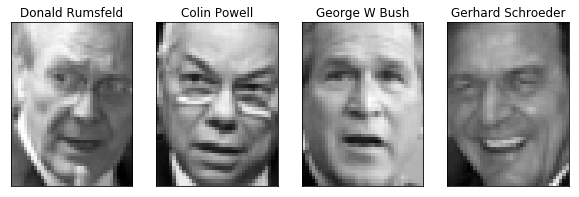

In [4]:
def plt_face(x):
    h = 50
    w = 37
    plt.imshow(x.reshape((h, w)), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    
I = np.random.permutation(n_samples)
plt.figure(figsize=(10,20))
nplt = 4;
for i in range(nplt):    
    ind = I[i]
    plt.subplot(1,nplt,i+1)
    plt_face(X[ind])
    plt.title(target_names[y[ind]])

## Principle Component Analysis

For PCA, we first subtract the sample mean from each feature (i.e., pixel).

In [5]:
Xmean = np.mean(X,0)
Xs = X - Xmean[None,:]

Then, we compute an SVD of the data matrix.  Note that, in Python, the SVD returns `V.T`, not `V`.  Also, by setting the `full_matrices` option to `False`, we get the *economy* SVD, where `U` may be tall and `VT` may be wide.

In [6]:
U,S,VT = np.linalg.svd(Xs, full_matrices=False)
VT.shape

(1288, 1850)

We can plot the proportion of variance as a function of the number of principle components.

Text(0, 0.5, 'PoV')

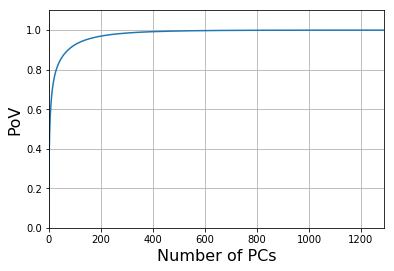

In [7]:
lam = S**2 / n_samples
PoV = np.cumsum(lam)/np.sum(lam)

plt.plot(PoV)
plt.grid()
plt.axis([1,n_samples,0, 1.1])
plt.xlabel('Number of PCs', fontsize=16)
plt.ylabel('PoV', fontsize=16)

From the plot above, we see that 400 components capture almost all the variance.

Next, we approximate the faces using only a few principle components

In [8]:
nsvd = 20
Xhat = (U[:,:nsvd]*S[None,:nsvd]).dot(VT[:nsvd,:])
Xhat = Xhat + Xmean[None,:]
Xhat.shape

(1288, 1850)

As we see above, the dimensions of Xhat are the same as those of X.  But we see below that the rank has decreased.  The rank is nsvd+1, where the +1 comes from adding the mean.

In [9]:
np.linalg.matrix_rank(Xhat)

21

In [10]:
# Note that instead of using linalg.svd, one can also use PCA method in sklearn

from sklearn.decomposition import PCA
pca = PCA(n_components=nsvd, svd_solver='randomized',
          whiten=True).fit(Xs)
eigenfaces = pca.components_
X_pca_coefficients = pca.transform(Xs)

## PCA approximation

For a couple of faces, let's plot the PCA approximation for several ranks.

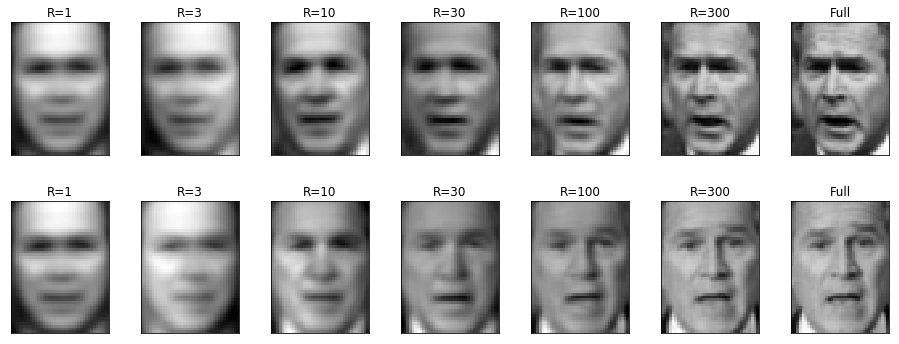

In [11]:
nplt = 2               # number of faces to plot
ds = [1,3,10,30,100,300]   # rank of approximation

# Select random faces
inds = np.random.permutation(n_samples)
inds = inds[:nplt]
nd = len(ds)

# Set figure size
plt.figure(figsize=(1.8 * (nd+1), 2.4 * nplt))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

# Loop over figures
iplt = 0
for ind in inds:
    for d in ds:
        plt.subplot(nplt,nd+1,iplt+1)
        Xhati = (U[ind,:d-1]*S[None,:d-1]).dot(VT[:d-1,:]) + Xmean
        plt_face(Xhati)
        plt.title('R={0:d}'.format(d))
        iplt += 1
    
    # Plot the true face
    plt.subplot(nplt,nd+1,iplt+1)
    plt_face(X[ind,:])
    plt.title('Full')
    iplt += 1

As expected, the approximation gets better as the rank increases.  

Let's also plot the mean face and the principle components (i.e., the eigenfaces)

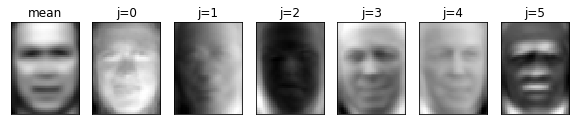

In [12]:
nplt = 6
plt.figure(figsize=(10, 20))
plt.subplot(1,nplt+1,1)
plt_face(Xmean)
plt.title('mean')
for i in range(nplt):
    plt.subplot(1,nplt+1,i+2)
    Vi = VT[i,:]
    plt_face(VT[i,:])
    plt.title('j={0:d}'.format(i))

## Face Recognition using PCA coefficients

We will use SVM to classify different faces based on the PCA coefficients

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

First of all, we need to seperate X and y to X_train, X_test, y_train, y_test.  Sklearn's train_test_split() function  makes this easy.  Given the relatively small amount of data, we will use the "stratify" option to ensure that the training set has the same proportion of different classes as the total dataset.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify = y, random_state=43)

We now compute the eigenfaces (i.e., principle components) using the training data only.

In [15]:
n_samples, _ = X_train.shape
Xtr_mean = np.mean(X_train,0)
Xtr = X_train - Xtr_mean[None,:]
Utr,Str,VTtr = np.linalg.svd(Xtr, full_matrices=False)

We will use the coefficients corresponding to 100 principle components for classification.  For best performance, this should be optimized.  The fewer we choose, the faster the classifier will run, but using more does not necessarily lead to better performance.  We first get the eigenfaces and eigen coefficients on training set.

In [16]:
npc = 100
eigenfaces = VTtr[:npc,:]
Ztr = Xtr.dot(eigenfaces.T)

# Note we could also use
# Ztr = Utr[:, :nsvd]*Str[None, :spc]

To use SVM, we should rescale the input features so that they all have unit variance.  Because the PCA coefficients have significantly different variances, this is particularly important. With SVD, the variance = eigenvalue = singular_value^2 / n_samples. So STDV = singular_value/sqrt(n_sample). Note that instead of scaling the PCA coefficients, one can also scale the principle components. So that using the scaled principle components, the coefficients will have unit variances.

In [17]:
Ztr_s = Ztr / Str[None,:npc] * np.sqrt(n_samples)

We will use GridSearchCV on the training data to find the optimal combination of C and gamma for the SVM.

In [18]:
param_grid = {'C': [1, 3, 10, 30, 100, 300],
              'gamma': [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5, iid=False)
clf = clf.fit(Ztr_s, y_train)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Cross validation accuracy with best estimator:")
print(clf.best_score_)

Best estimator found by grid search:
SVC(C=3, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.003, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Cross validation accuracy with best estimator:
0.8506081737123565


Now we evaluate the model accuracy on the test set. But first we must apply the same preprocessing as we did on the training data.

In [19]:
Xts = X_test - Xtr_mean[None,:]
Zts = Xts.dot(eigenfaces.T)
Zts_s = Zts / Str[None,:npc] * np.sqrt(n_samples)
y_hat = clf.predict(Zts_s)
acc = np.mean(y_hat==y_test)
print("The model accuracy on the test set is %f" % acc)

The model accuracy on the test set is 0.829193


We can use following tools to print classification performance.

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(y_test, y_hat, target_names=target_names))
print("Confusion matrix on the test data")
print(confusion_matrix(y_test, y_hat, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.68      0.70        19
     Colin Powell       0.79      0.88      0.83        59
  Donald Rumsfeld       0.67      0.73      0.70        30
    George W Bush       0.91      0.87      0.89       133
Gerhard Schroeder       0.81      0.81      0.81        27
      Hugo Chavez       1.00      0.67      0.80        18
       Tony Blair       0.79      0.83      0.81        36

        micro avg       0.83      0.83      0.83       322
        macro avg       0.81      0.78      0.79       322
     weighted avg       0.84      0.83      0.83       322

Confusion matrix on the test data
[[ 13   3   2   1   0   0   0]
 [  1  52   1   3   1   0   1]
 [  2   1  22   4   1   0   0]
 [  1   6   7 116   1   0   2]
 [  0   0   0   1  22   0   4]
 [  1   2   0   1   1  12   1]
 [  0   2   1   2   1   0  30]]


We can plot some correctly classified faces and the corresponding PCA face approximations:

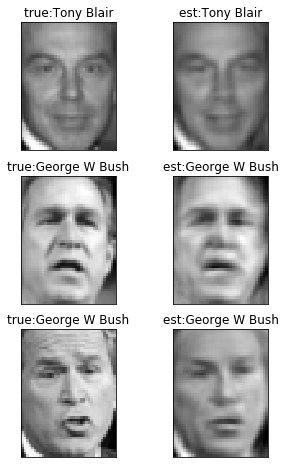

In [21]:
nplt = 3
correct_index = np.where(y_hat==y_test)[0][:nplt]
correct_origin = X_test[correct_index, :]
correct_pca = Zts[correct_index, :].dot(eigenfaces) +  Xtr_mean[None,:]
plt.figure(figsize=(5, 8))
for i in range(nplt):
    plt.subplot(nplt,2,2*i+1)
    plt_face(correct_origin[i,:])
    plt.title('true:'+target_names[y_test[correct_index[i]]])
    
    plt.subplot(nplt,2,2*i+2)
    plt_face(correct_pca[i,:])
    plt.title('est:'+target_names[y_hat[correct_index[i]]])
plt.show()

Now let's plot some incorrectly classified faces and the corresponding PCA face approximations:

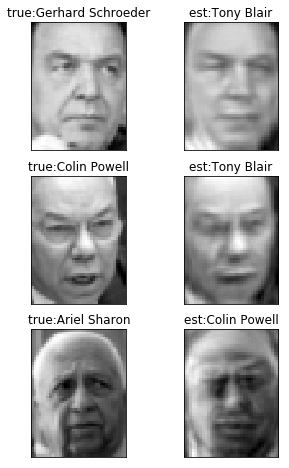

In [22]:
nplt = 3
wrong_index = np.where(y_hat!=y_test)[0][:nplt]
wrong_origin = X_test[wrong_index, :]
wrong_pca = Zts[wrong_index, :].dot(eigenfaces) +  Xtr_mean[None,:]
plt.figure(figsize=(5, 8))
for i in range(nplt):
    plt.subplot(nplt,2,2*i+1)
    plt_face(wrong_origin[i,:])
    plt.title('true:'+target_names[y_test[wrong_index[i]]])
    
    plt.subplot(nplt,2,2*i+2)
    plt_face(wrong_pca[i,:])
    plt.title('est:'+target_names[y_hat[wrong_index[i]]])
plt.show()